In [16]:
import os
import shutil
import random
import hashlib
import numpy as np
import tensorflow as tf
import joblib
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import seaborn as sns
from PIL import Image
from tensorflow.keras.preprocessing import image


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import (
    ResNet50,
    VGG16,
    VGG19,
    EfficientNetB0,
    MobileNetV2)

from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    cohen_kappa_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc
)

from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Dense,
    BatchNormalization,
    GlobalAveragePooling2D,
    Dropout,
    Flatten
)

In [4]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 25
LR = 1e-4


In [2]:
import pandas as pd

results_df = pd.read_csv("results/model_results.csv")
results_df


,Classifier,Precision (%),Recall (%),F1-Score (%),Accuracy (%),Kappa
0,EfficientNetB0,88.536696,88.630807,88.519648,88.630807,0.846043
1,ResNet50,91.156910,91.136919,91.109133,91.136919,0.879995
2,VGG16,91.156910,91.136919,91.109133,91.136919,0.879995
3,VGG19,86.868805,87.041565,86.913223,87.041565,0.824142
4,MobileNetV2,73.451100,73.533007,70.414726,73.533007,0.634926
5,CustomCNN,77.449483,78.056235,77.219705,78.056235,0.700274
6,Logistic Regression,91.693345,91.748166,91.706698,91.748166,0.888038
7,KNN,91.513879,91.564792,91.439923,91.564792,0.885428
8,SVM,96.937606,96.943765,96.934544,96.943765,0.958561
9,Random Forest,86.591575,86.369193,86.132901,86.369193,0.815177


In [ ]:
# daha önce yaptığım future extraction sonuçlarını yüklüyorum 
X_train_feat = np.load("features/X_train_feat.npy")
y_train_feat = np.load("features/y_train_feat.npy")

X_test_feat  = np.load("features/X_test_feat.npy")
y_test_feat  = np.load("features/y_test_feat.npy")

In [66]:
import os
import numpy as np
import pandas as pd

from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    cohen_kappa_score
)

def evaluate_and_store(
    model,
    generator,
    model_name,
    results_csv="results/model_results.csv"
):
    """
    Modeli test setinde değerlendirir ve sonuçları CSV dosyasına kaydeder
    """

    y_true = generator.classes
    y_prob = model.predict(generator)
    y_pred = np.argmax(y_prob, axis=1)

    row = {
        "Classifier": model_name,
        "Precision (%)": precision_score(y_true, y_pred, average="weighted") * 100,
        "Recall (%)": recall_score(y_true, y_pred, average="weighted") * 100,
        "F1-Score (%)": f1_score(y_true, y_pred, average="weighted") * 100,
        "Accuracy (%)": accuracy_score(y_true, y_pred) * 100,
        "Kappa": cohen_kappa_score(y_true, y_pred)
    }

    os.makedirs(os.path.dirname(results_csv), exist_ok=True)

    if os.path.exists(results_csv):
        df = pd.read_csv(results_csv)
        df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
    else:
        df = pd.DataFrame([row])

    df.to_csv(results_csv, index=False)

    print(f"✅ {model_name} sonuçları kaydedildi.")


In [28]:

class_names = ["glioma" ,"emningioma" , "notumor" , "pituitary"]

### datasetteki ortak resimleri temizleme

In [ ]:
# datasette birden fazla kopyası olan resimleri temizler 

RAW_DIR = "dataset_raw_auto"
os.makedirs(RAW_DIR, exist_ok=True)

def file_hash(path):
    with open(path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

seen_hashes = set()

def merge_train_test_to_raw_dedup():
    for cls in os.listdir(TRAIN_SRC):
        cls_raw = os.path.join(RAW_DIR, cls)
        os.makedirs(cls_raw, exist_ok=True)

        for src_dir in [TRAIN_SRC, TEST_SRC]:
            for f in os.listdir(os.path.join(src_dir, cls)):
                if f.startswith("."):
                    continue

                src = os.path.join(src_dir, cls, f)
                h = file_hash(src)

                # ❗ Daha önce gördüysek atla
                if h in seen_hashes:
                    continue

                seen_hashes.add(h)

                dst = os.path.join(cls_raw, f)
                shutil.copy(src, dst)

merge_train_test_to_raw_dedup()


In [39]:
SPLIT_DIR = "dataset_split"
SPLITS = {"train": 0.7, "val": 0.15, "test": 0.15}

for split in SPLITS:
    for cls in os.listdir(RAW_DIR):
        os.makedirs(os.path.join(SPLIT_DIR, split, cls), exist_ok=True)

for cls in os.listdir(RAW_DIR):
    files = [f for f in os.listdir(os.path.join(RAW_DIR, cls)) if not f.startswith(".")]
    random.shuffle(files)

    n = len(files)
    t = int(n * 0.7)
    v = int(n * 0.85)

    split_map = {
        "train": files[:t],
        "val": files[t:v],
        "test": files[v:]
    }

    for split, flist in split_map.items():
        for f in flist:
            shutil.copy(
                os.path.join(RAW_DIR, cls, f),
                os.path.join(SPLIT_DIR, split, cls, f)
            )


In [137]:
train_hashes = build_hash_set("dataset_split/train")
test_hashes  = build_hash_set("dataset_split/test")

print("Gerçek aynı görüntü sayısı:", len(train_hashes & test_hashes))


NameError: name 'build_hash_set' is not defined

### data augmentation

In [ ]:
# daha iyi bir accuracy için fotoğraflar üzerinde bazı oynamalar yapar
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


In [69]:
SPLIT_DIR = "dataset_split"

train_gen = train_datagen.flow_from_directory(
    f"{SPLIT_DIR}/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=True,
    seed=SEED
)

val_gen = val_test_datagen.flow_from_directory(
    f"{SPLIT_DIR}/val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=False
)

test_gen = val_test_datagen.flow_from_directory(
    f"{SPLIT_DIR}/test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=False
)


Found 7622 images belonging to 4 classes.
Found 1634 images belonging to 4 classes.
Found 1636 images belonging to 4 classes.


In [70]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)

class_weights = {int(i): float(w) for i, w in enumerate(class_weights)}
class_weights


{0: 0.7374226006191951,
 1: 1.1430713857228554,
 2: 1.291864406779661,
 3: 1.0050105485232068}

### EDA

In [ ]:
# data hakkında daha detaylı bilgi ediniliyor

base_dir = "dataset_split"
splits = ["train", "val", "test"]

for split in splits:
    print(f"\n📂 {split.upper()} SETİ")
    split_dir = os.path.join(base_dir, split)
    
    for class_name in os.listdir(split_dir):
        class_path = os.path.join(split_dir, class_name)
        
        if os.path.isdir(class_path):
            num_images = len([
                f for f in os.listdir(class_path)
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))
            ])
            print(f"  {class_name}: {num_images} görüntü")



📂 TRAIN SETİ
  pituitary: 1896 görüntü
  notumor: 1475 görüntü
  glioma: 2584 görüntü
  meningioma: 1667 görüntü

📂 VAL SETİ
  pituitary: 407 görüntü
  notumor: 316 görüntü
  glioma: 554 görüntü
  meningioma: 357 görüntü

📂 TEST SETİ
  pituitary: 407 görüntü
  notumor: 317 görüntü
  glioma: 554 görüntü
  meningioma: 358 görüntü


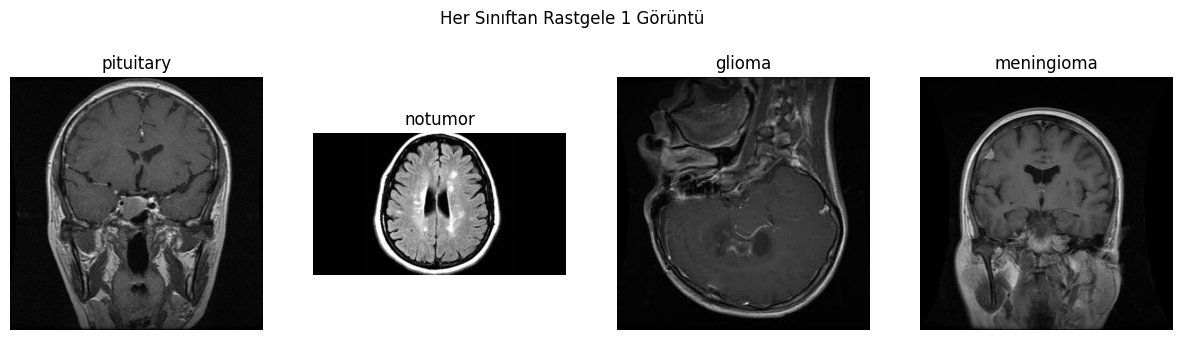

In [8]:
train_dir = "dataset_split/train"

classes = [
    d for d in os.listdir(train_dir)
    if os.path.isdir(os.path.join(train_dir, d))
]

plt.figure(figsize=(15, 4))

for i, class_name in enumerate(classes):
    class_path = os.path.join(train_dir, class_name)
    
    images = [
        f for f in os.listdir(class_path)
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))
    ]
    
    img_name = random.choice(images)
    img_path = os.path.join(class_path, img_name)
    
    img = Image.open(img_path)
    
    plt.subplot(1, len(classes), i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")

plt.suptitle("Her Sınıftan Rastgele 1 Görüntü")
plt.show()


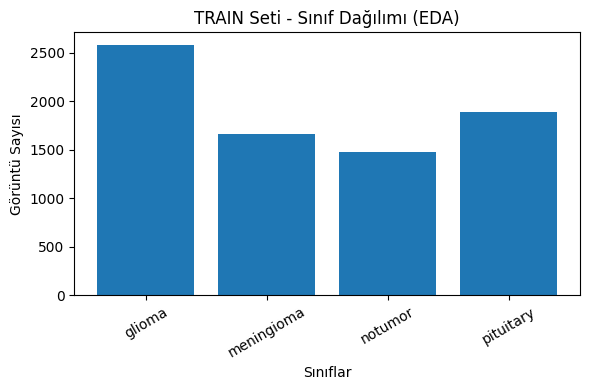

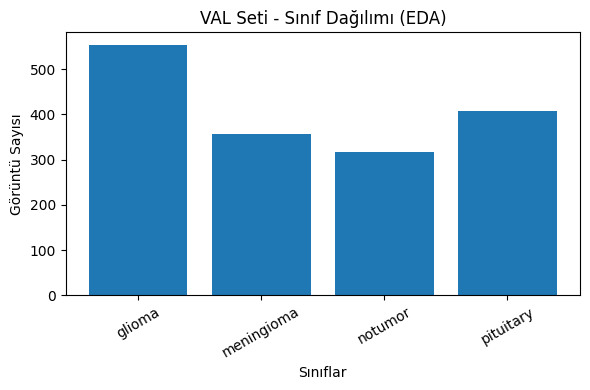

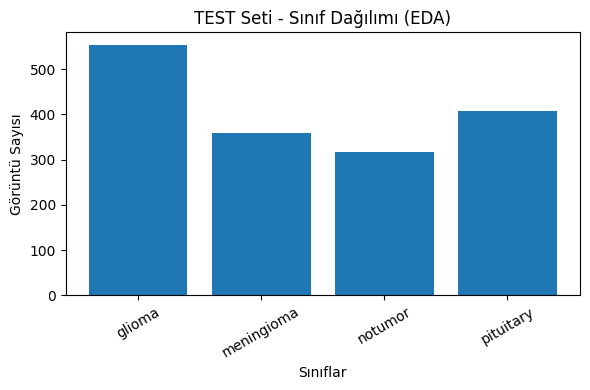

In [9]:
base_dir = "dataset_split"
splits = ["train", "val", "test"]

for split in splits:
    split_dir = os.path.join(base_dir, split)
    
    class_names = []
    class_counts = []
    
    for class_name in sorted(os.listdir(split_dir)):
        class_path = os.path.join(split_dir, class_name)
        
        if os.path.isdir(class_path):
            count = len([
                f for f in os.listdir(class_path)
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))
            ])
            class_names.append(class_name)
            class_counts.append(count)
    
    # Grafik
    plt.figure(figsize=(6, 4))
    plt.bar(class_names, class_counts)
    plt.title(f"{split.upper()} Seti - Sınıf Dağılımı (EDA)")
    plt.xlabel("Sınıflar")
    plt.ylabel("Görüntü Sayısı")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


### Grafikler

In [71]:
FIG_DIR = "results/figures"

In [72]:
def plot_accuracy_loss(history, model_name="Model", save=True):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{model_name} - Accuracy")
    plt.legend()
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{model_name} - Loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()

    if save:
        plt.savefig(
            f"{FIG_DIR}/{model_name}_accuracy_loss.png",
            dpi=300,
            bbox_inches="tight"
        )

    plt.show()


In [73]:
def plot_confusion_matrix(model, generator, class_names, model_name="Model", save=True):
    y_true = generator.classes
    y_prob = model.predict(generator)
    y_pred = y_prob.argmax(axis=1)

    cm = confusion_matrix(y_true, y_pred)

    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=class_names
    )

    plt.figure(figsize=(6,6))
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"{model_name} - Confusion Matrix")

    if save:
        plt.savefig(
            f"{FIG_DIR}/{model_name}_confusion_matrix.png",
            dpi=300,
            bbox_inches="tight"
        )

    plt.show()


In [74]:
def plot_roc_curves(model, generator, class_names, model_name="Model", save=True):
    y_true = generator.classes
    y_score = model.predict(generator)

    n_classes = len(class_names)
    y_true_bin = label_binarize(y_true, classes=range(n_classes))

    plt.figure(figsize=(7,6))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC={roc_auc:.2f})")

    plt.plot([0,1], [0,1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} - ROC Curves")
    plt.legend(loc="lower right")
    plt.grid(True)

    if save:
        plt.savefig(
            f"{FIG_DIR}/{model_name}_roc.png",
            dpi=300,
            bbox_inches="tight"
        )

    plt.show()


In [ ]:
def evaluate_and_store_ml(
    model,
    X_test,
    y_test,
    model_name,
    results_csv="results/model_results.csv"
):
    y_pred = model.predict(X_test)

    row = {
        "Classifier": model_name,
        "Accuracy (%)": accuracy_score(y_test, y_pred) * 100,
        "Precision (%)": precision_score(y_test, y_pred, average="weighted") * 100,
        "Recall (%)": recall_score(y_test, y_pred, average="weighted") * 100,
        "F1-Score (%)": f1_score(y_test, y_pred, average="weighted") * 100,
        "Kappa": cohen_kappa_score(y_test, y_pred)
    }

    os.makedirs(os.path.dirname(results_csv), exist_ok=True)

    if os.path.exists(results_csv):
        df = pd.read_csv(results_csv)
        df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
    else:
        df = pd.DataFrame([row])

    df.to_csv(results_csv, index=False)

    print(f"{model_name} sonuçları kaydedildi.")


In [113]:
def plot_confusion_matrix_ml(model, X_test, y_test, class_names, model_name):
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=class_names)

    plt.figure(figsize=(6,6))
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"{model_name} - Confusion Matrix")

    plt.savefig(
        f"{FIG_DIR}/{model_name}_confusion_matrix.png",
        dpi=300,
        bbox_inches="tight"
    )
    plt.show()


In [114]:
def plot_roc_curves_ml(model, X_test, y_test, class_names, model_name):
    if not hasattr(model, "predict_proba"):
        print(f"{model_name} ROC desteklemiyor.")
        return

    y_score = model.predict_proba(X_test)
    y_bin = label_binarize(y_test, classes=range(len(class_names)))

    plt.figure(figsize=(7,6))

    for i, cls in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{cls} (AUC={roc_auc:.2f})")

    plt.plot([0,1], [0,1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} - ROC Curves")
    plt.legend(loc="lower right")

    plt.savefig(
        f"{FIG_DIR}/{model_name}_roc.png",
        dpi=300,
        bbox_inches="tight"
    )
    plt.show()


In [115]:
def plot_accuracy_bar_ml(model, X_test, y_test, model_name):
    acc = accuracy_score(y_test, model.predict(X_test))

    plt.figure(figsize=(4,5))
    plt.bar([model_name], [acc])
    plt.ylim(0, 1)
    plt.ylabel("Accuracy")
    plt.title(f"{model_name} - Test Accuracy")

    plt.savefig(
        f"{FIG_DIR}/{model_name}_accuracy.png",
        dpi=300,
        bbox_inches="tight"
    )
    plt.show()


### Feature Extraction

In [ ]:
# ML modellerini eğitmek için feature extraciton
feature_extractor = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

feature_extractor.trainable = False


2025-12-22 19:12:48.603080: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-12-22 19:12:48.604202: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-12-22 19:12:48.604207: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-12-22 19:12:48.605004: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-22 19:12:48.605724: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [20]:
feature_extractor = tf.keras.Sequential([
    feature_extractor,
    GlobalAveragePooling2D()
])


In [96]:
import numpy as np

def extract_features(generator, model):
    features = []
    labels = []

    for i in range(len(generator)):
        x_batch, y_batch = generator[i]
        
        feat_batch = model.predict(x_batch, verbose=0)
        features.append(feat_batch)
        labels.append(y_batch)

    X = np.vstack(features)
    y = np.concatenate(labels)

    return X, y


In [97]:
X_train_feat, y_train_feat = extract_features(train_gen, feature_extractor)
X_val_feat,   y_val_feat   = extract_features(val_gen, feature_extractor)
X_test_feat,  y_test_feat  = extract_features(test_gen, feature_extractor)

print(X_train_feat.shape, X_test_feat.shape)


(7622, 1280) (1636, 1280)


In [ ]:
# özelliklerin kaydedilmesi 
os.makedirs("features", exist_ok=True)

np.save("features/X_train_feat.npy", X_train_feat)
np.save("features/y_train_feat.npy", y_train_feat)

np.save("features/X_val_feat.npy",   X_val_feat)
np.save("features/y_val_feat.npy",   y_val_feat)

np.save("features/X_test_feat.npy",  X_test_feat)
np.save("features/y_test_feat.npy",  y_test_feat)


### EfficientNetB0

In [ ]:
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(train_gen.num_classes, activation="softmax")(x)

model_eff = tf.keras.Model(inputs=base_model.input, outputs=output)


In [49]:
model_eff.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
# eğer accuracy artmazsa epoch yarıda kesmemizi sağlıyor
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history = model_eff.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stop]
)


Epoch 1/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 186s 358ms/step - accuracy: 0.6186 - loss: 0.8958 - val_accuracy: 0.7778 - val_loss: 0.5986
Epoch 2/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 162s 339ms/step - accuracy: 0.7604 - loss: 0.6082 - val_accuracy: 0.8231 - val_loss: 0.4763
Epoch 3/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 165s 344ms/step - accuracy: 0.7886 - loss: 0.5326 - val_accuracy: 0.8341 - val_loss: 0.4269
Epoch 4/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 163s 341ms/step - accuracy: 0.8090 - loss: 0.4934 - val_accuracy: 0.8409 - val_loss: 0.4290
Epoch 5/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 163s 340ms/step - accuracy: 0.8225 - loss: 0.4625 - val_accuracy: 0.8543 - val_loss: 0.3914
Epoch 6/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 164s 343ms/step - accuracy: 0.8275 - loss: 0.4411 - val_accuracy: 0.8562 - val_loss: 0.3849
Epoch 7/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 166s 347ms/step - accuracy: 0.8378 - loss: 0.4218 - val_accuracy: 0.8770 - val_loss: 0.3381
Epoch 8/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 166s 345ms/step - accuracy: 0.8456 -

In [ ]:
#bilgisayar kapandıktan sonra tekrardan modeli yüklüyorum 
from tensorflow.keras.models import load_model

MODEL_PATH = "models/efficientnet_b0_10epoch.h5"
model_eff = load_model(MODEL_PATH)
model_eff.summary()


2025-12-19 20:25:37.843055: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-12-19 20:25:37.843611: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-12-19 20:25:37.843615: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-12-19 20:25:37.843689: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-19 20:25:37.845652: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,378,537 (16.70 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 2 (12.00 B)

In [ ]:
import numpy as np

y_true = test_gen.classes              
y_prob = model_eff.predict(test_gen)   
y_pred = np.argmax(y_prob, axis=1)     


2025-12-19 20:55:46.014620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 166ms/step


In [51]:
test_loss, test_acc = model_eff.evaluate(test_gen)
print(f"EfficientNetB0 Test Accuracy: {test_acc:.4f}")


103/103 ━━━━━━━━━━━━━━━━━━━━ 25s 239ms/step - accuracy: 0.8863 - loss: 0.2989
EfficientNetB0 Test Accuracy: 0.8863


In [52]:
import os
os.makedirs("models", exist_ok=True)
model_eff.save("models/efficientnet_b0_10epoch.h5")


In [17]:
from sklearn.metrics import accuracy_score

test_acc = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.8863


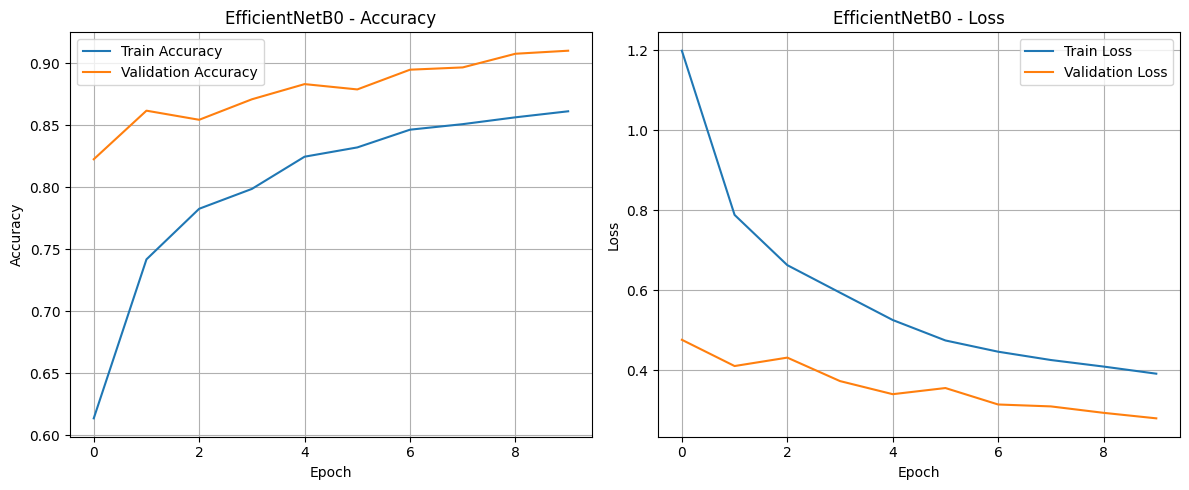

103/103 ━━━━━━━━━━━━━━━━━━━━ 22s 208ms/step


<Figure size 600x600 with 0 Axes>

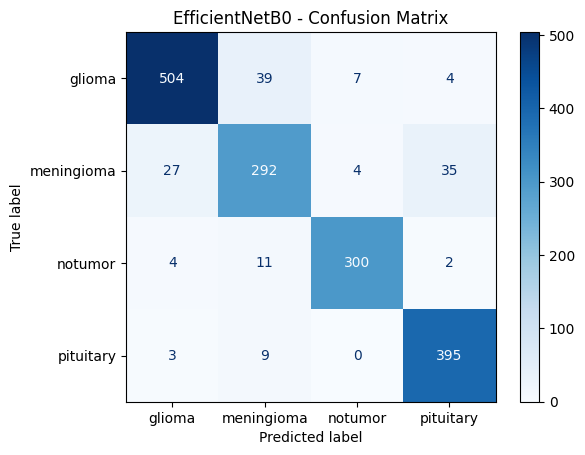

103/103 ━━━━━━━━━━━━━━━━━━━━ 21s 200ms/step


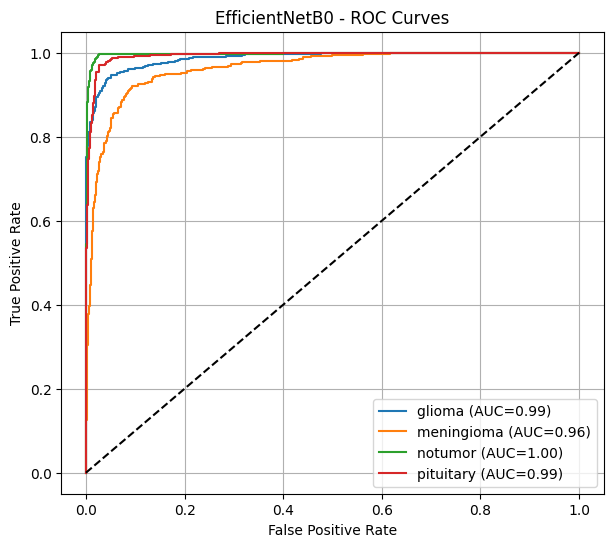

In [45]:
plot_accuracy_loss(history_resnet, "EfficientNetB0")
plot_confusion_matrix(model_resnet, test_gen, class_names, "EfficientNetB0")
plot_roc_curves(model_resnet, test_gen, class_names, "EfficientNetB0")

In [43]:
evaluate_and_store(
    model_eff,
    test_gen,
    "EfficientNetB0"
)


103/103 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step


### ResNet50

In [ ]:
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(train_gen.num_classes, activation="softmax")(x)

model_resnet = tf.keras.Model(
    inputs=base_model.input,
    outputs=output
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 16s 0us/step


In [23]:
model_resnet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [26]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

history_resnet = model_resnet.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=[early_stop]
)


Epoch 1/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 132s 263ms/step - accuracy: 0.6136 - loss: 1.1985 - val_accuracy: 0.8225 - val_loss: 0.4765
Epoch 2/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 140s 294ms/step - accuracy: 0.7418 - loss: 0.7884 - val_accuracy: 0.8617 - val_loss: 0.4110
Epoch 3/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 150s 314ms/step - accuracy: 0.7826 - loss: 0.6630 - val_accuracy: 0.8543 - val_loss: 0.4320
Epoch 4/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 140s 293ms/step - accuracy: 0.7986 - loss: 0.5943 - val_accuracy: 0.8709 - val_loss: 0.3734
Epoch 5/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 150s 315ms/step - accuracy: 0.8246 - loss: 0.5259 - val_accuracy: 0.8831 - val_loss: 0.3407
Epoch 6/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 158s 332ms/step - accuracy: 0.8321 - loss: 0.4749 - val_accuracy: 0.8788 - val_loss: 0.3560
Epoch 7/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 167s 349ms/step - accuracy: 0.8464 - loss: 0.4468 - val_accuracy: 0.8947 - val_loss: 0.3149
Epoch 8/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 172s 360ms/step - accuracy: 0.8508 -

In [29]:
test_loss, test_acc = model_resnet.evaluate(test_gen)
print(f"ResNet50 Test Accuracy: {test_acc:.4f}")


103/103 ━━━━━━━━━━━━━━━━━━━━ 19s 182ms/step - accuracy: 0.9114 - loss: 0.2648
ResNet50 Test Accuracy: 0.9114


In [30]:
import os
os.makedirs("models", exist_ok=True)
model_resnet.save("models/resnet50_10epoch.h5")


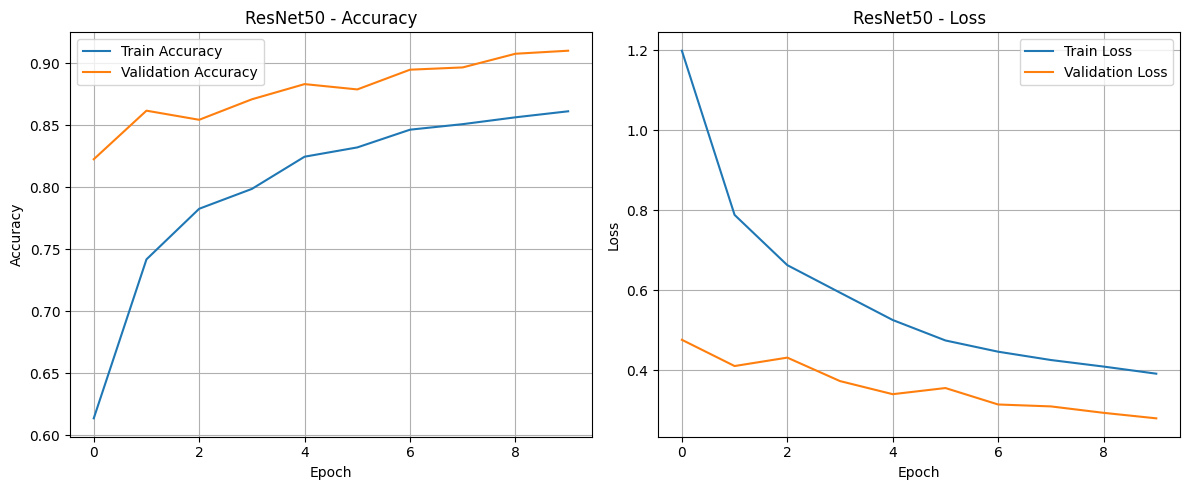

103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 190ms/step


<Figure size 600x600 with 0 Axes>

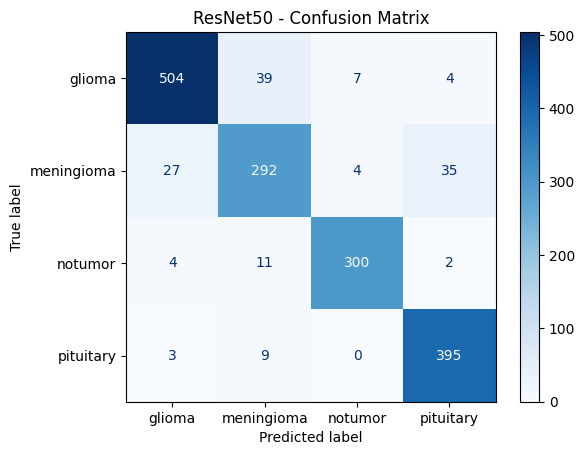

103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 193ms/step


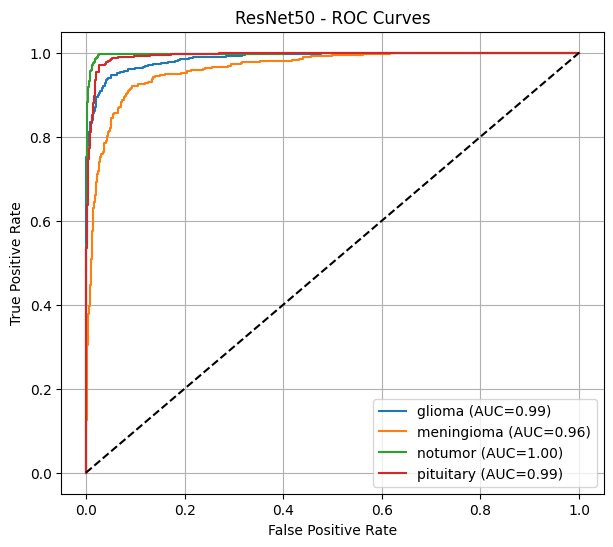

In [40]:
plot_accuracy_loss(history_resnet, "ResNet50")
plot_confusion_matrix(model_resnet, test_gen, class_names, "ResNet50")
plot_roc_curves(model_resnet, test_gen, class_names, "ResNet50")

In [42]:
import pandas as pd
import os

def evaluate_and_store(
    model,
    generator,
    model_name,
    results_csv="results/model_results.csv"
):
    from sklearn.metrics import (
        precision_score, recall_score,
        f1_score, accuracy_score, cohen_kappa_score
    )
    import numpy as np

    y_true = generator.classes
    y_prob = model.predict(generator)
    y_pred = np.argmax(y_prob, axis=1)

    row = {
        "Classifier": model_name,
        "Precision (%)": precision_score(y_true, y_pred, average="weighted") * 100,
        "Recall (%)": recall_score(y_true, y_pred, average="weighted") * 100,
        "F1-Score (%)": f1_score(y_true, y_pred, average="weighted") * 100,
        "Accuracy (%)": accuracy_score(y_true, y_pred) * 100,
        "Kappa": cohen_kappa_score(y_true, y_pred)
    }

    # Eğer dosya varsa EKLE, yoksa oluştur
    if os.path.exists(results_csv):
        df = pd.read_csv(results_csv)
        df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
    else:
        df = pd.DataFrame([row])

    df.to_csv(results_csv, index=False)


In [44]:
evaluate_and_store(
    model_resnet,
    test_gen,
    "ResNet50"
)


103/103 ━━━━━━━━━━━━━━━━━━━━ 20s 193ms/step


### VGG16

In [ ]:
IMG_SIZE = (224, 224)
LR = 1e-4
EPOCHS = 10

base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(train_gen.num_classes, activation="softmax")(x)

model_vgg16 = tf.keras.Model(inputs=base_model.input, outputs=output)


In [51]:
model_vgg16.compile(
    optimizer=Adam(LR),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [52]:
callbacks = [
    EarlyStopping(
        patience=3,
        restore_best_weights=True
    )
]


In [53]:
history_vgg16 = model_vgg16.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 260s 538ms/step - accuracy: 0.4612 - loss: 4.0539 - val_accuracy: 0.7607 - val_loss: 1.2424
Epoch 2/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 277s 580ms/step - accuracy: 0.6528 - loss: 2.2831 - val_accuracy: 0.8054 - val_loss: 1.0067
Epoch 3/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 292s 612ms/step - accuracy: 0.6965 - loss: 1.9151 - val_accuracy: 0.8188 - val_loss: 1.0427
Epoch 4/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 351s 735ms/step - accuracy: 0.7233 - loss: 1.6906 - val_accuracy: 0.8433 - val_loss: 0.8877
Epoch 5/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 360s 754ms/step - accuracy: 0.7456 - loss: 1.4775 - val_accuracy: 0.8513 - val_loss: 0.8265
Epoch 6/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 347s 727ms/step - accuracy: 0.7553 - loss: 1.3527 - val_accuracy: 0.8617 - val_loss: 0.7168
Epoch 7/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 340s 712ms/step - accuracy: 0.7733 - loss: 1.1833 - val_accuracy: 0.8666 - val_loss: 0.6533
Epoch 8/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 341s 715ms/step - accuracy: 0.7767 -

In [54]:
import os
os.makedirs("models", exist_ok=True)

model_vgg16.save("models/vgg16_10epoch.h5")


In [55]:
test_loss, test_acc = model_vgg16.evaluate(test_gen)
print(f"VGG16 Test Accuracy: {test_acc:.4f}")


103/103 ━━━━━━━━━━━━━━━━━━━━ 29s 280ms/step - accuracy: 0.8851 - loss: 0.4882
VGG16 Test Accuracy: 0.8851


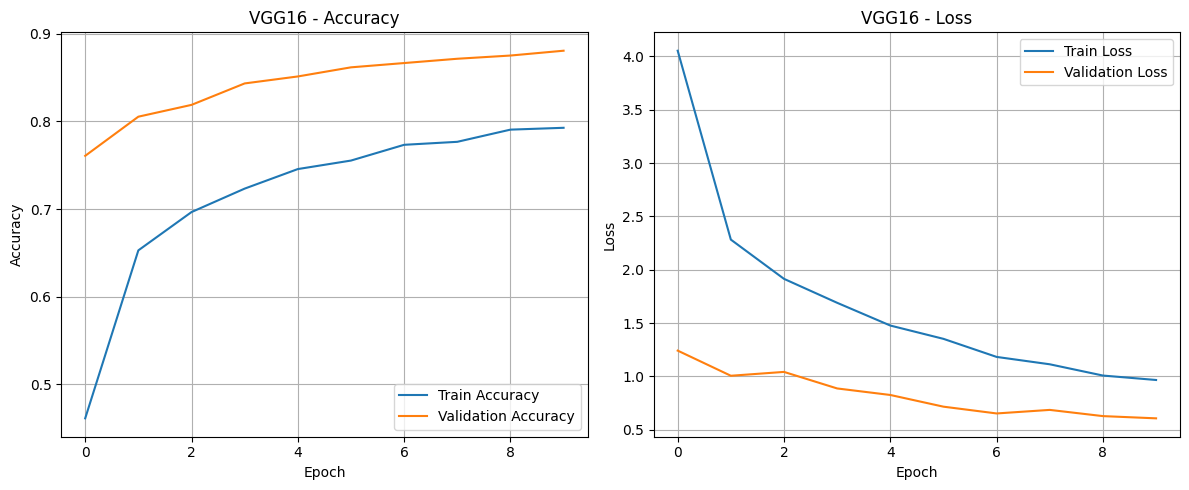

103/103 ━━━━━━━━━━━━━━━━━━━━ 32s 303ms/step


<Figure size 600x600 with 0 Axes>

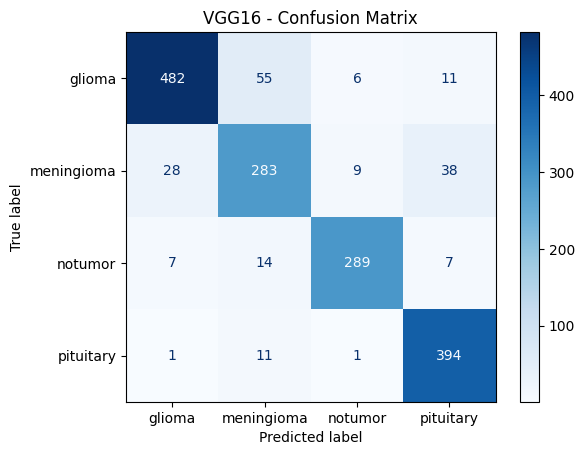

103/103 ━━━━━━━━━━━━━━━━━━━━ 35s 345ms/step


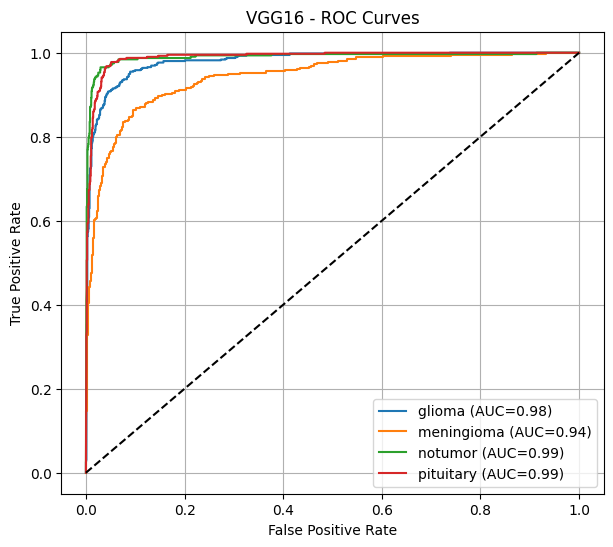

In [56]:
plot_accuracy_loss(history_vgg16, "VGG16")
plot_confusion_matrix(model_vgg16, test_gen, class_names, "VGG16")
plot_roc_curves(model_vgg16, test_gen, class_names, "VGG16")


In [57]:
evaluate_and_store(
    model_resnet,
    test_gen,
    "VGG16"
)


103/103 ━━━━━━━━━━━━━━━━━━━━ 29s 264ms/step


### VGG19

In [ ]:
IMG_SIZE = (224, 224)
LR = 1e-4
EPOCHS = 10

base_model = VGG19(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(train_gen.num_classes, activation="softmax")(x)

model_vgg19 = tf.keras.Model(
    inputs=base_model.input,
    outputs=output
)


2025-12-20 09:38:39.944713: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-12-20 09:38:39.945227: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-12-20 09:38:39.945235: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-12-20 09:38:39.946099: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-20 09:38:39.946813: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [12]:
model_vgg19.compile(
    optimizer=Adam(LR),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [13]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    )
]


In [14]:
history_vgg19 = model_vgg19.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/10


2025-12-20 09:39:30.131940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


477/477 ━━━━━━━━━━━━━━━━━━━━ 213s 445ms/step - accuracy: 0.4822 - loss: 3.2566 - val_accuracy: 0.7521 - val_loss: 1.0308
Epoch 2/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 279s 585ms/step - accuracy: 0.6224 - loss: 2.1974 - val_accuracy: 0.7815 - val_loss: 0.9939
Epoch 3/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 375s 787ms/step - accuracy: 0.6669 - loss: 1.8449 - val_accuracy: 0.8140 - val_loss: 0.8583
Epoch 4/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 389s 816ms/step - accuracy: 0.7074 - loss: 1.5400 - val_accuracy: 0.8231 - val_loss: 0.7978
Epoch 5/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 398s 834ms/step - accuracy: 0.7179 - loss: 1.4800 - val_accuracy: 0.8378 - val_loss: 0.7570
Epoch 6/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 393s 823ms/step - accuracy: 0.7326 - loss: 1.3462 - val_accuracy: 0.8274 - val_loss: 0.7918
Epoch 7/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 401s 841ms/step - accuracy: 0.7469 - loss: 1.2056 - val_accuracy: 0.8268 - val_loss: 0.7681
Epoch 8/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 411s 862ms/step - accuracy: 0.7682 - loss: 1.10

In [15]:
os.makedirs("models", exist_ok=True)
model_vgg19.save("models/vgg19_10epoch.h5")


In [16]:
test_loss, test_acc = model_vgg19.evaluate(test_gen)
print(f"VGG19 Test Accuracy: {test_acc:.4f}")


103/103 ━━━━━━━━━━━━━━━━━━━━ 30s 293ms/step - accuracy: 0.8704 - loss: 0.5167
VGG19 Test Accuracy: 0.8704


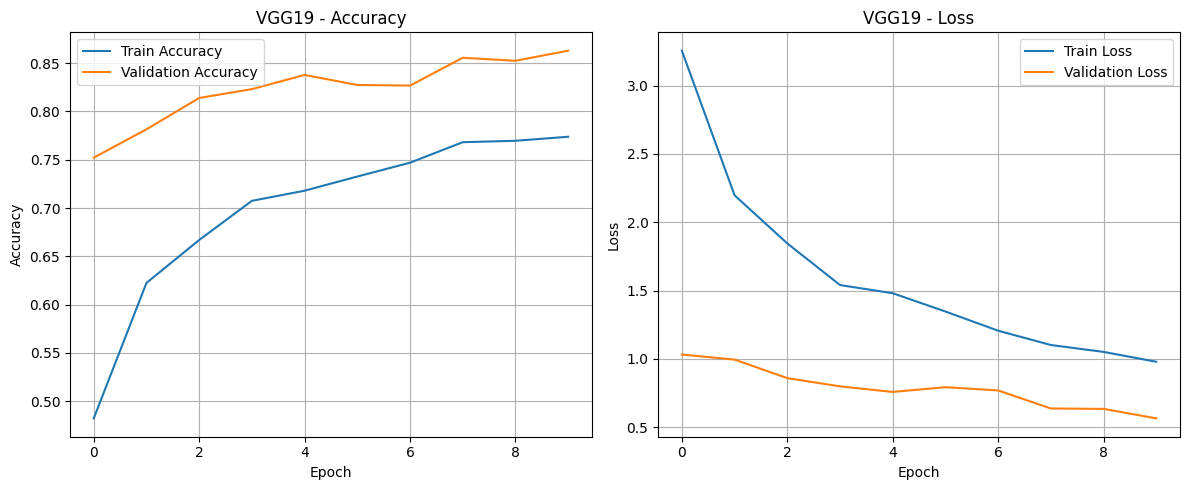

103/103 ━━━━━━━━━━━━━━━━━━━━ 30s 291ms/step


<Figure size 600x600 with 0 Axes>

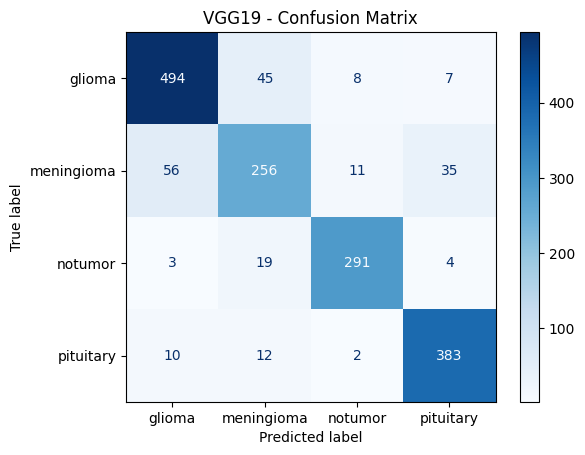

103/103 ━━━━━━━━━━━━━━━━━━━━ 32s 315ms/step


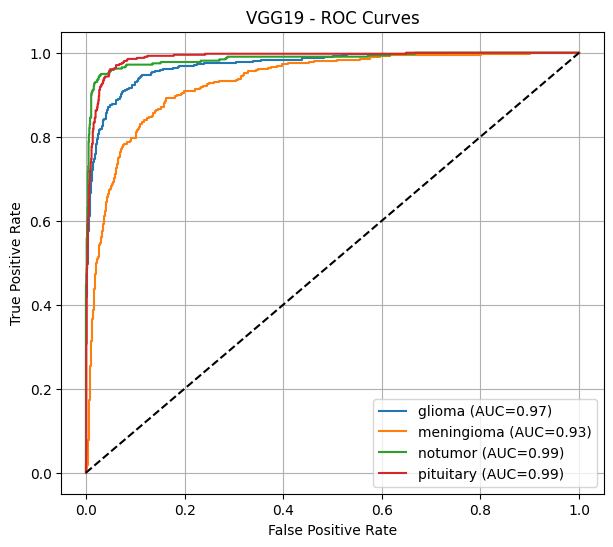

In [27]:
plot_accuracy_loss(history_vgg19, "VGG19")
plot_confusion_matrix(model_vgg19, test_gen, class_names, "VGG19")
plot_roc_curves(model_vgg19, test_gen, class_names, "VGG19")


In [30]:
evaluate_and_store(
    model_vgg19,
    test_gen,
    "VGG19"
)

103/103 ━━━━━━━━━━━━━━━━━━━━ 31s 300ms/step
✅ VGG19 sonuçları kaydedildi.


### MobileNetV2

In [ ]:
IMG_SIZE = (224, 224)
LR = 1e-4
EPOCHS = 10

base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(train_gen.num_classes, activation="softmax")(x)

model_mobilenet = tf.keras.Model(
    inputs=base_model.input,
    outputs=output
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [36]:
model_mobilenet.compile(
    optimizer=Adam(LR),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [37]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    )
]


In [38]:
history_mobilenet = model_mobilenet.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 71s 141ms/step - accuracy: 0.5146 - loss: 1.2986 - val_accuracy: 0.6787 - val_loss: 0.8318
Epoch 2/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 74s 154ms/step - accuracy: 0.6185 - loss: 1.0270 - val_accuracy: 0.6952 - val_loss: 0.7576
Epoch 3/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 86s 179ms/step - accuracy: 0.6425 - loss: 0.9570 - val_accuracy: 0.7209 - val_loss: 0.6926
Epoch 4/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 91s 190ms/step - accuracy: 0.6657 - loss: 0.8838 - val_accuracy: 0.7099 - val_loss: 0.7179
Epoch 5/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 83s 173ms/step - accuracy: 0.6918 - loss: 0.8246 - val_accuracy: 0.7246 - val_loss: 0.6827
Epoch 6/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 81s 170ms/step - accuracy: 0.7003 - loss: 0.7842 - val_accuracy: 0.7362 - val_loss: 0.6637
Epoch 7/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 86s 180ms/step - accuracy: 0.7142 - loss: 0.7583 - val_accuracy: 0.7319 - val_loss: 0.6757
Epoch 8/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 69s 144ms/step - accuracy: 0.7255 - loss: 0

In [39]:
model_mobilenet.save("models/mobilenetv2_10epoch.h5")


In [40]:
test_loss, test_acc = model_mobilenet.evaluate(test_gen)
print(f"MobileNetV2 Test Accuracy: {test_acc:.4f}")


103/103 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.7353 - loss: 0.6508
MobileNetV2 Test Accuracy: 0.7353


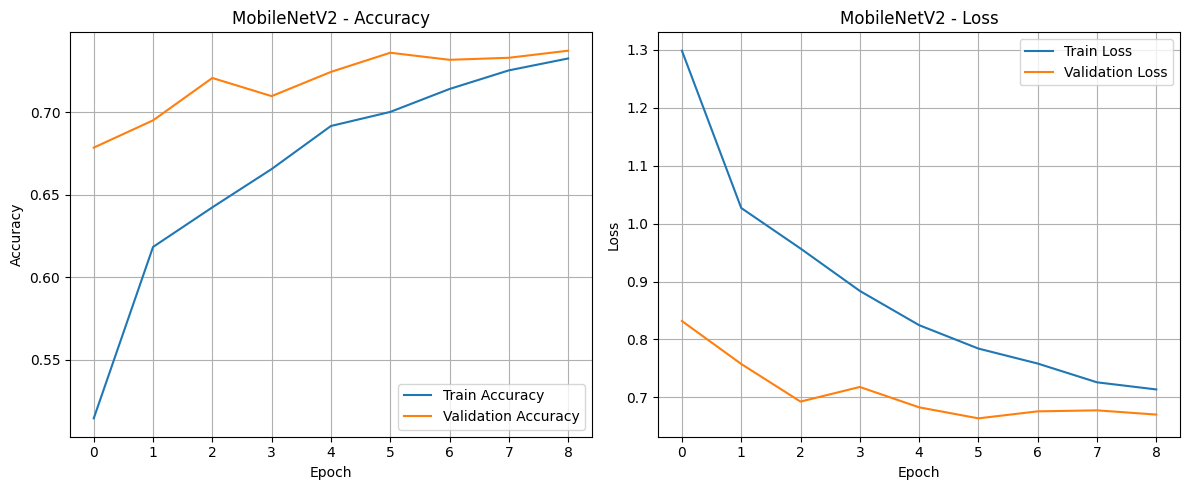

103/103 ━━━━━━━━━━━━━━━━━━━━ 14s 114ms/step


<Figure size 600x600 with 0 Axes>

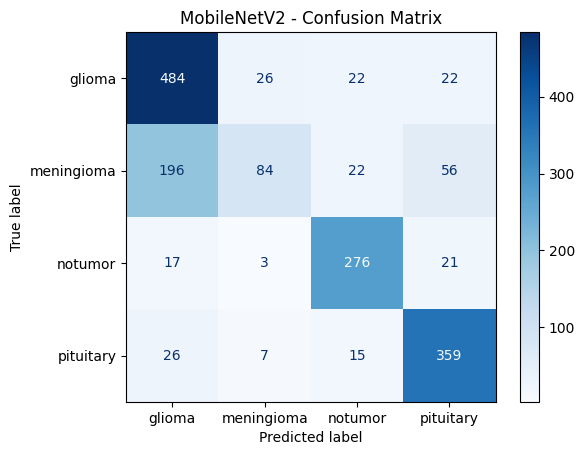

103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step


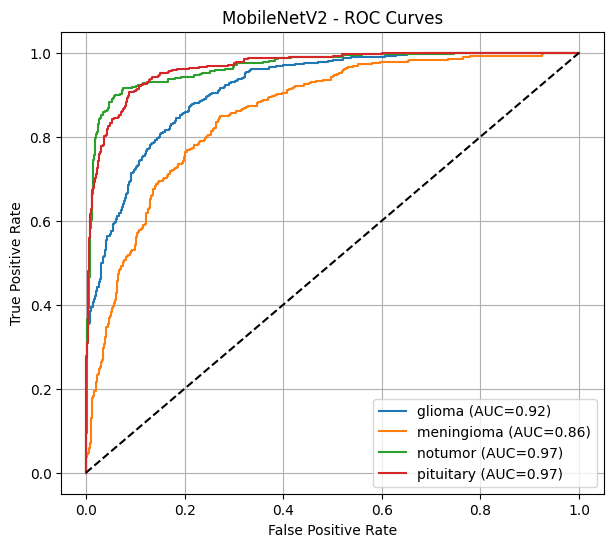

In [41]:
plot_accuracy_loss(history_mobilenet, "MobileNetV2")
plot_confusion_matrix(model_mobilenet, test_gen, class_names, "MobileNetV2")
plot_roc_curves(model_mobilenet, test_gen, class_names, "MobileNetV2")


In [42]:
evaluate_and_store(
    model_mobilenet,
    test_gen,
    "MobileNetV2"
)


103/103 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step
✅ MobileNetV2 sonuçları kaydedildi.


### Custom CNN

In [85]:
optimizer = Adam(learning_rate=5e-5)

callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    )
]


In [86]:
model_custom = Sequential([
    # Block 1
    Conv2D(32, (3,3), padding="same", activation="relu",
           input_shape=(224,224,3)),
    BatchNormalization(),
    MaxPooling2D(),

    # Block 2
    Conv2D(64, (3,3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(),

    # Block 3
    Conv2D(128, (3,3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(),

    # Block 4
    Conv2D(256, (3,3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(),

    # Classification head
    GlobalAveragePooling2D(),

    Dense(256, activation="relu"),
    Dropout(0.4),

    Dense(train_gen.num_classes, activation="softmax")
])


In [89]:
model_custom.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [90]:
history_custom = model_custom.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 127s 248ms/step - accuracy: 0.5117 - loss: 1.1624 - val_accuracy: 0.6359 - val_loss: 1.0668
Epoch 2/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 124s 260ms/step - accuracy: 0.5782 - loss: 1.0329 - val_accuracy: 0.5912 - val_loss: 1.0351
Epoch 3/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 127s 265ms/step - accuracy: 0.6081 - loss: 0.9728 - val_accuracy: 0.6536 - val_loss: 1.0551
Epoch 4/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 132s 277ms/step - accuracy: 0.6329 - loss: 0.9152 - val_accuracy: 0.6830 - val_loss: 0.9081
Epoch 5/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 129s 270ms/step - accuracy: 0.6614 - loss: 0.8673 - val_accuracy: 0.7062 - val_loss: 0.8155
Epoch 6/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 134s 280ms/step - accuracy: 0.6776 - loss: 0.8403 - val_accuracy: 0.7222 - val_loss: 0.7263
Epoch 7/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 139s 291ms/step - accuracy: 0.6939 - loss: 0.8048 - val_accuracy: 0.7723 - val_loss: 0.7203
Epoch 8/10
477/477 ━━━━━━━━━━━━━━━━━━━━ 144s 301ms/step - accuracy: 0.7128 -

In [91]:
test_loss, test_acc = model_custom.evaluate(test_gen)
print(f"Custom CNN Test Accuracy: {test_acc:.4f}")


103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.7806 - loss: 0.5963
Custom CNN Test Accuracy: 0.7806


In [92]:
model_custom.save("models/custom_cnn_10epoch.h5")


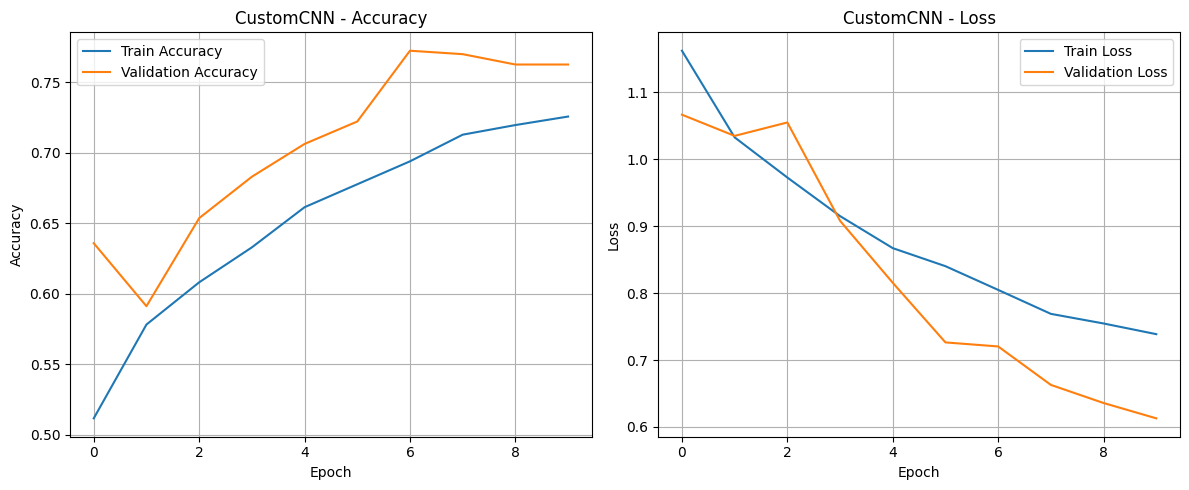

103/103 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step


<Figure size 600x600 with 0 Axes>

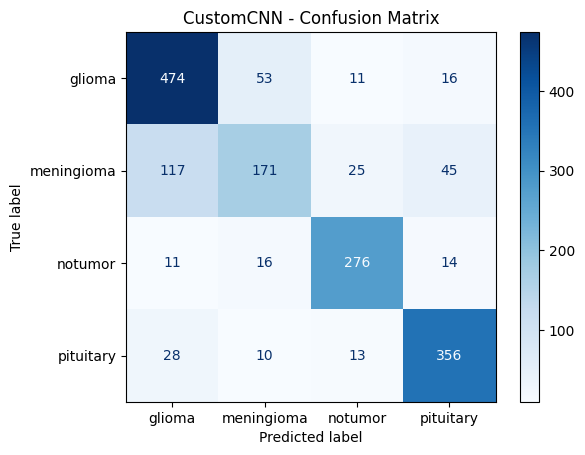

103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step


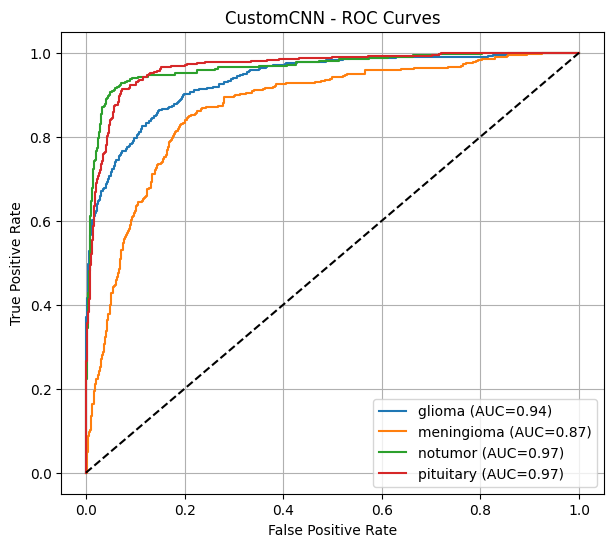

103/103 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step
✅ CustomCNN sonuçları kaydedildi.


In [93]:
plot_accuracy_loss(history_custom, "CustomCNN")
plot_confusion_matrix(model_custom, test_gen, class_names, "CustomCNN")
plot_roc_curves(model_custom, test_gen, class_names, "CustomCNN")

evaluate_and_store(
    model_custom,
    test_gen,
    "CustomCNN"
)


### ML Modelleri 

In [100]:

X_train_feat = np.load("features/X_train_feat.npy")
y_train_feat = np.load("features/y_train_feat.npy")

X_test_feat  = np.load("features/X_test_feat.npy")
y_test_feat  = np.load("features/y_test_feat.npy")

In [101]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train_feat)
X_test  = scaler.transform(X_test_feat)


In [102]:
lr_model = LogisticRegression(
    max_iter=3000,
    n_jobs=-1
)


In [103]:
knn_model = KNeighborsClassifier(
    n_neighbors=7,
    weights="distance"
)


In [104]:
svm_model = SVC(
    kernel="rbf",
    C=10,
    gamma="scale",
    probability=True
)


In [105]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)


In [ ]:
lr_model.fit(X_train, y_train_feat)
knn_model.fit(X_train, y_train_feat)
svm_model.fit(X_train, y_train_feat)

# Random Forest - scale edilmemiş feature
rf_model.fit(X_train_feat, y_train_feat)


/Users/berkekutay/Desktop/YZ Proje/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [108]:
evaluate_and_store_ml(lr_model,  X_test,      y_test_feat, "Logistic Regression")
evaluate_and_store_ml(knn_model, X_test,      y_test_feat, "KNN")
evaluate_and_store_ml(svm_model, X_test,      y_test_feat, "SVM")
evaluate_and_store_ml(rf_model,  X_test_feat, y_test_feat, "Random Forest")


✅ Logistic Regression sonuçları kaydedildi.
✅ KNN sonuçları kaydedildi.
✅ SVM sonuçları kaydedildi.
✅ Random Forest sonuçları kaydedildi.


In [112]:
MODEL_DIR = "models"

joblib.dump(lr_model,  f"{MODEL_DIR}/logistic_regression.pkl")
joblib.dump(knn_model, f"{MODEL_DIR}/knn.pkl")
joblib.dump(svm_model, f"{MODEL_DIR}/svm.pkl")
joblib.dump(rf_model,  f"{MODEL_DIR}/random_forest.pkl")


['models/random_forest.pkl']

<Figure size 600x600 with 0 Axes>

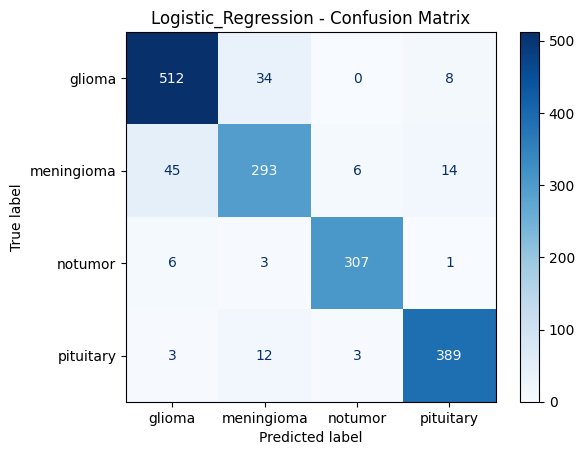

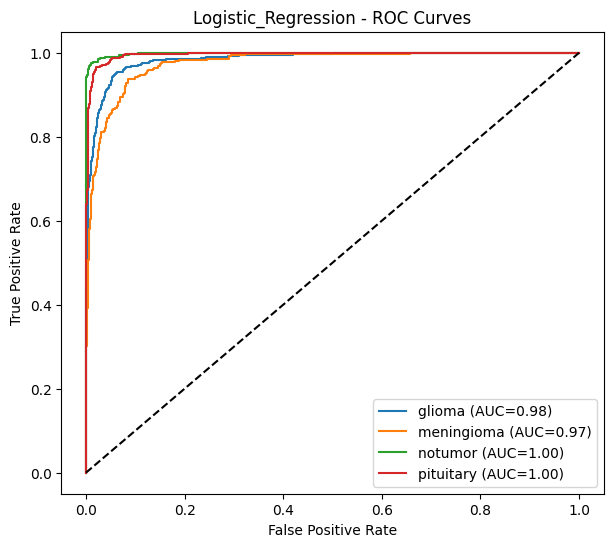

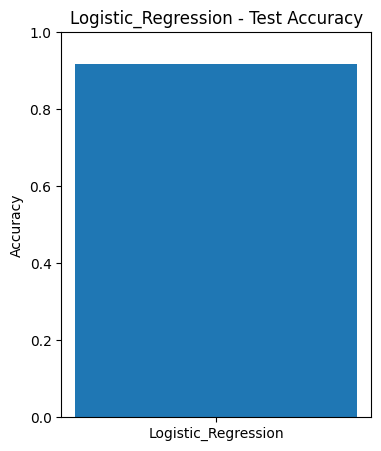

In [116]:
plot_confusion_matrix_ml(lr_model, X_test, y_test_feat, class_names, "Logistic_Regression")
plot_roc_curves_ml(lr_model, X_test, y_test_feat, class_names, "Logistic_Regression")
plot_accuracy_bar_ml(lr_model, X_test, y_test_feat, "Logistic_Regression")


<Figure size 600x600 with 0 Axes>

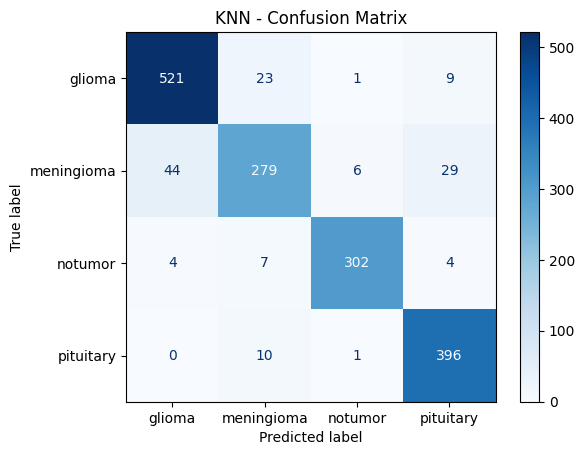

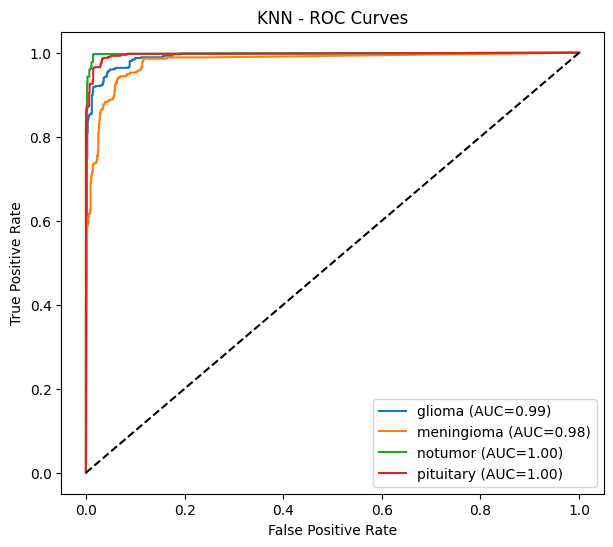

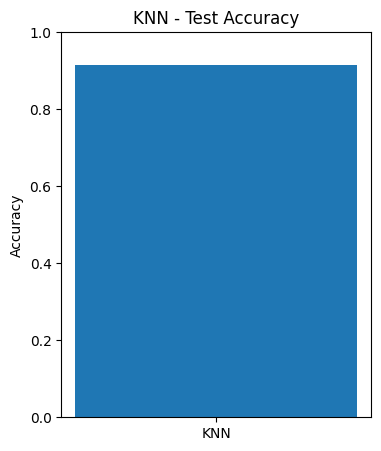

In [117]:
plot_confusion_matrix_ml(knn_model, X_test, y_test_feat, class_names, "KNN")
plot_roc_curves_ml(knn_model, X_test, y_test_feat, class_names, "KNN")
plot_accuracy_bar_ml(knn_model, X_test, y_test_feat, "KNN")


<Figure size 600x600 with 0 Axes>

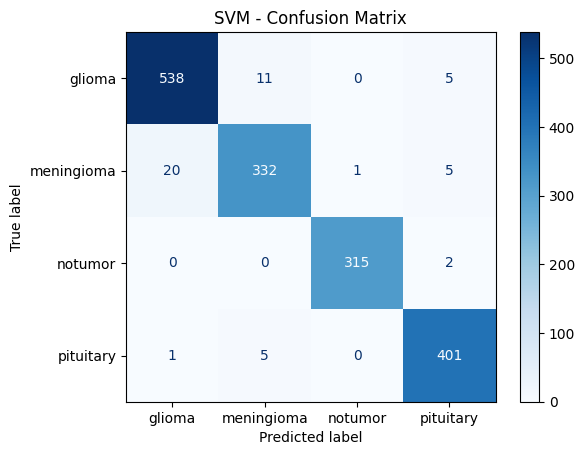

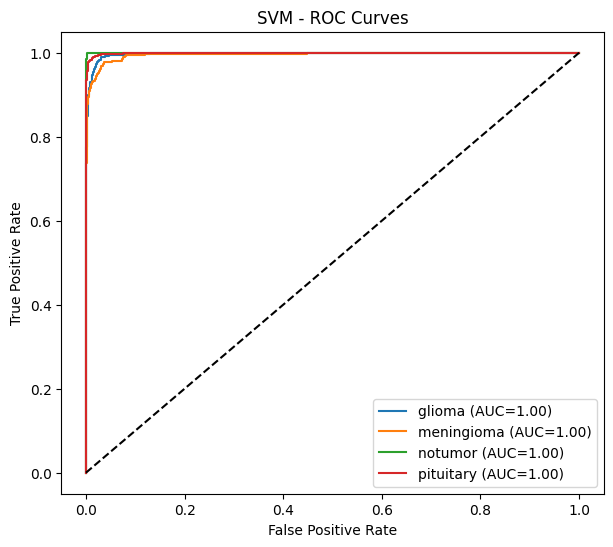

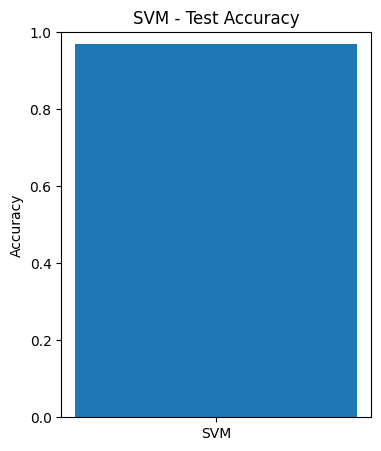

In [118]:
plot_confusion_matrix_ml(svm_model, X_test, y_test_feat, class_names, "SVM")
plot_roc_curves_ml(svm_model, X_test, y_test_feat, class_names, "SVM")
plot_accuracy_bar_ml(svm_model, X_test, y_test_feat, "SVM")


<Figure size 600x600 with 0 Axes>

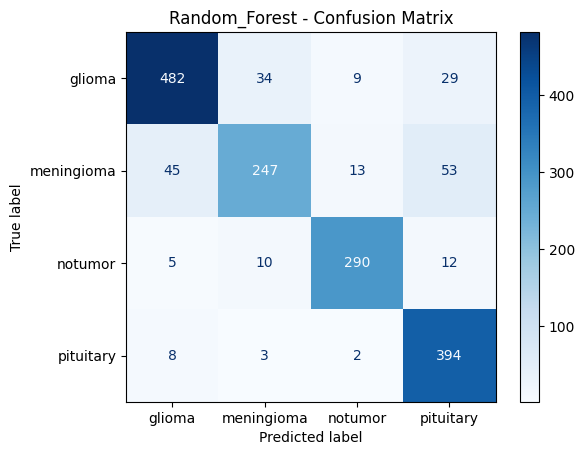

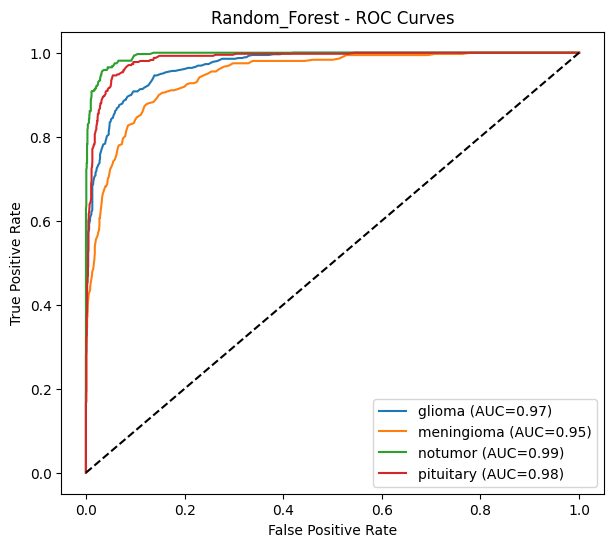

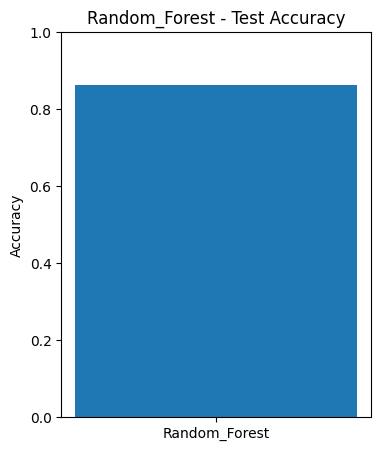

In [119]:
plot_confusion_matrix_ml(rf_model, X_test_feat, y_test_feat, class_names, "Random_Forest")
plot_roc_curves_ml(rf_model, X_test_feat, y_test_feat, class_names, "Random_Forest")
plot_accuracy_bar_ml(rf_model, X_test_feat, y_test_feat, "Random_Forest")


In [122]:
import os
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    cohen_kappa_score
)

RESULTS_CSV = "results/model_results.csv"

def evaluate_and_store_ml(
    model,
    X_test,
    y_test,
    model_name,
    model_type="ML"
):
    y_pred = model.predict(X_test)

    row = {
        "Model": model_name,
        "Type": model_type,
        "Accuracy (%)": accuracy_score(y_test, y_pred) * 100,
        "Precision (%)": precision_score(y_test, y_pred, average="weighted") * 100,
        "Recall (%)": recall_score(y_test, y_pred, average="weighted") * 100,
        "F1-Score (%)": f1_score(y_test, y_pred, average="weighted") * 100,
        "Kappa": cohen_kappa_score(y_test, y_pred)
    }

    # Dosya varsa ekle, yoksa oluştur
    if os.path.exists(RESULTS_CSV):
        df = pd.read_csv(RESULTS_CSV)
        df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
    else:
        df = pd.DataFrame([row])

    df.to_csv(RESULTS_CSV, index=False)

    print(f"✅ {model_name} sonuçları results/model_results.csv dosyasına kaydedildi.")


In [123]:
evaluate_and_store_ml(
    lr_model,
    X_test,
    y_test_feat,
    "Logistic Regression"
)


✅ Logistic Regression sonuçları results/model_results.csv dosyasına kaydedildi.


In [124]:
evaluate_and_store_ml(
    knn_model,
    X_test,
    y_test_feat,
    "KNN"
)


✅ KNN sonuçları results/model_results.csv dosyasına kaydedildi.


In [125]:
evaluate_and_store_ml(
    svm_model,
    X_test,
    y_test_feat,
    "SVM"
)


✅ SVM sonuçları results/model_results.csv dosyasına kaydedildi.


In [126]:
evaluate_and_store_ml(
    rf_model,
    X_test_feat,
    y_test_feat,
    "Random Forest"
)


✅ Random Forest sonuçları results/model_results.csv dosyasına kaydedildi.


### EfficientNetB0 + SVM

In [6]:
TRAIN_DIR = "dataset_split/train"
TEST_DIR  = "dataset_split/test"

feat_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_feat_gen = feat_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224,224),
    batch_size=32,
    class_mode="sparse",
    shuffle=False
)

test_feat_gen = feat_gen.flow_from_directory(
    TEST_DIR,
    target_size=(224,224),
    batch_size=32,
    class_mode="sparse",
    shuffle=False
)


Found 7622 images belonging to 4 classes.
Found 1636 images belonging to 4 classes.


In [7]:
eff_b0 = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    pooling="avg",
    input_shape=(224,224,3)
)
eff_b0.trainable = False


2025-12-21 11:59:21.090493: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-12-21 11:59:21.090746: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-12-21 11:59:21.090752: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-12-21 11:59:21.091076: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-21 11:59:21.091890: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
svm_hybrid = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(
        kernel="rbf",
        C=10,
        gamma="scale",
        probability=True,
        random_state=42
    ))
])


In [11]:
svm_hybrid.fit(X_train_feat, y_train_feat)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('svm', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",10
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'


In [12]:
joblib.dump(svm_hybrid, "models/efficientnetb0_svm.pkl")


['models/efficientnetb0_svm.pkl']

In [17]:
FIG_DIR = "results/figures"

def plot_confusion_matrix_ml(
    y_true,
    y_pred,
    class_names,
    model_name
):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )

    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"{model_name} - Confusion Matrix")

    plt.savefig(
        f"{FIG_DIR}/{model_name}_confusion_matrix.png",
        dpi=300,
        bbox_inches="tight"
    )
    plt.show()


In [18]:
def plot_roc_curves_ml(
    y_true,
    y_prob,
    class_names,
    model_name
):
    y_bin = label_binarize(
        y_true,
        classes=range(len(class_names))
    )

    plt.figure(figsize=(7,6))

    for i, cls in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(
            fpr,
            tpr,
            label=f"{cls} (AUC={roc_auc:.2f})"
        )

    plt.plot([0,1], [0,1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{model_name} - ROC Curves")
    plt.legend(loc="lower right")

    plt.savefig(
        f"{FIG_DIR}/{model_name}_roc.png",
        dpi=300,
        bbox_inches="tight"
    )
    plt.show()


In [19]:
def plot_accuracy_bar_ml(
    y_true,
    y_pred,
    model_name
):
    acc = accuracy_score(y_true, y_pred)

    plt.figure(figsize=(4,5))
    plt.bar([model_name], [acc])
    plt.ylim(0, 1)
    plt.ylabel("Accuracy")
    plt.title(f"{model_name} - Test Accuracy")

    plt.savefig(
        f"{FIG_DIR}/{model_name}_accuracy.png",
        dpi=300,
        bbox_inches="tight"
    )
    plt.show()


In [20]:
RESULTS_CSV = "results/model_results.csv"

In [21]:
def evaluate_and_store_ml(
    y_true,
    y_pred,
    model_name
):
    row = {
        "Model": model_name,
        "Accuracy (%)": accuracy_score(y_true, y_pred) * 100,
        "Precision (%)": precision_score(
            y_true, y_pred, average="weighted"
        ) * 100,
        "Recall (%)": recall_score(
            y_true, y_pred, average="weighted"
        ) * 100,
        "F1-Score (%)": f1_score(
            y_true, y_pred, average="weighted"
        ) * 100,
        "Kappa": cohen_kappa_score(y_true, y_pred)
    }

    if os.path.exists(RESULTS_CSV):
        df = pd.read_csv(RESULTS_CSV)
        df = pd.concat(
            [df, pd.DataFrame([row])],
            ignore_index=True
        )
    else:
        df = pd.DataFrame([row])

    df.to_csv(RESULTS_CSV, index=False)

    print(f"✅ {model_name} sonuçları kaydedildi.")


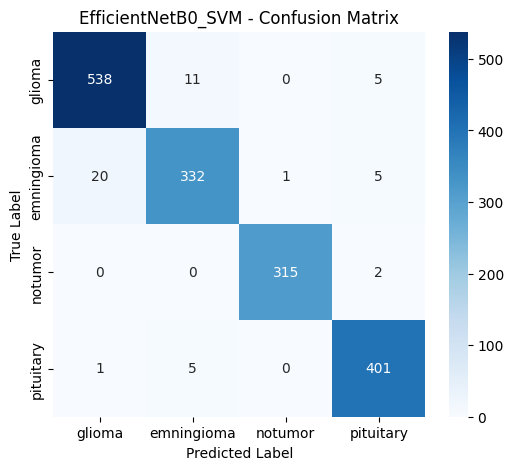

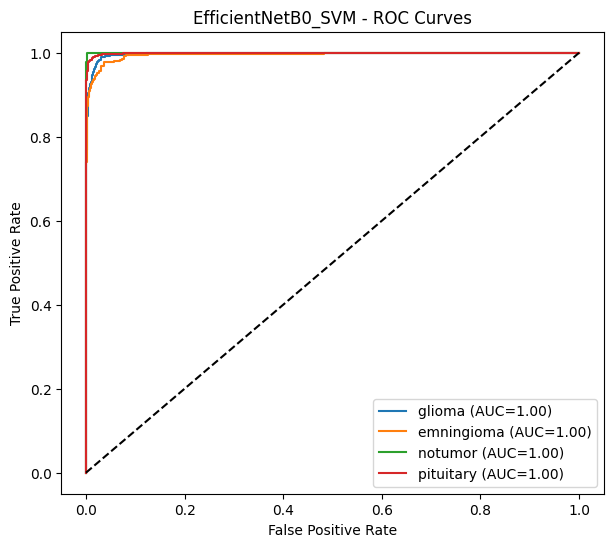

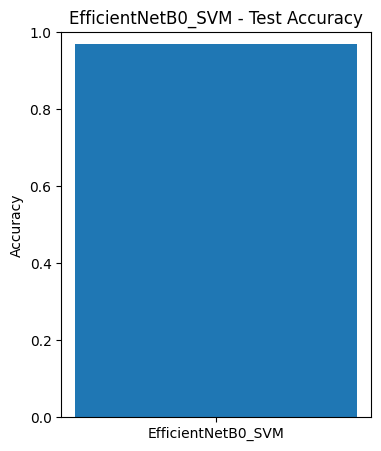

✅ EfficientNetB0_SVM sonuçları kaydedildi.


In [38]:
# Tahminler
y_pred = svm_hybrid.predict(X_test_feat)
y_prob = svm_hybrid.predict_proba(X_test_feat)

# Grafikler
plot_confusion_matrix_ml(
    y_test_feat,
    y_pred,
    class_names,
    "EfficientNetB0_SVM"
)

plot_roc_curves_ml(
    y_test_feat,
    y_prob,
    class_names,
    "EfficientNetB0_SVM"
)

plot_accuracy_bar_ml(
    y_test_feat,
    y_pred,
    "EfficientNetB0_SVM"
)

# CSV kaydı
evaluate_and_store_ml(
    y_test_feat,
    y_pred,
    "EfficientNetB0_SVM"
)


### Overfitting

In [46]:
def check_overfitting(history, model_name="Model"):
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"], label="Train Acc")
    plt.plot(history.history["val_accuracy"], label="Val Acc")
    plt.title(f"{model_name} - Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title(f"{model_name} - Loss")
    plt.legend()

    plt.show()


In [48]:
check_overfitting(history_eff, "EfficientNetB0")


NameError: name 'history_eff' is not defined

In [ ]:
def overfitting_score(history):
    acc_gap  = history.history["accuracy"][-1] - history.history["val_accuracy"][-1]
    loss_gap = history.history["val_loss"][-1] - history.history["loss"][-1]
    
    print(f"Accuracy farkı (Train - Val): {acc_gap:.3f}")
    print(f"Loss farkı (Val - Train): {loss_gap:.3f}")


In [52]:
train_acc = history.history["accuracy"][-1]
val_acc   = history.history["val_accuracy"][-1]
test_loss, test_acc = model.evaluate(test_gen)

print(f"Train Acc: {train_acc:.3f}")
print(f"Val Acc:   {val_acc:.3f}")
print(f"Test Acc:  {test_acc:.3f}")


NameError: name 'history' is not defined

In [53]:
locals().keys()


dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', 'open', '_', '__', '___', '__vsc_ipynb_file__', '_i', '_ii', '_iii', '_i1', '_i2', '_i3', 'os', 'shutil', 'random', 'hashlib', 'np', 'tf', 'joblib', 'plt', 'Pipeline', 'ImageDataGenerator', 'preprocess_input', 'Adam', 'EarlyStopping', 'ReduceLROnPlateau', 'compute_class_weight', 'ResNet50', 'VGG16', 'VGG19', 'EfficientNetB0', 'MobileNetV2', 'label_binarize', 'Sequential', 'StandardScaler', 'LogisticRegression', 'KNeighborsClassifier', 'SVC', 'RandomForestClassifier', 'precision_score', 'recall_score', 'f1_score', 'accuracy_score', 'cohen_kappa_score', 'confusion_matrix', 'ConfusionMatrixDisplay', 'roc_curve', 'auc', 'Conv2D', 'MaxPooling2D', 'Dense', 'BatchNormalization', 'GlobalAveragePooling2D', 'Dropout', 'Flatten', '_i4', 'SEED', 'IMG_SIZE', 'BATCH_SIZE', 'EPOCHS', 'LR', '_i5', 'pd', 'results_df', '_5', '_i6', 'TR

In [56]:

test_loss, test_acc = model_eff.evaluate(test_gen)
print("EfficientNet Test Accuracy:", test_acc)


NameError: name 'model_eff' is not defined

In [51]:
[k for k in locals().keys() if "history" in k.lower()]


[]

### En İyi Model

In [10]:
import pandas as pd

results_df = pd.read_csv("results/model_results.csv")

best_model = results_df.loc[
    results_df["Accuracy (%)"].idxmax()
]

print("En iyi model:")
print(best_model)


En iyi model:
Classifier             SVM
Precision (%)    96.937606
Recall (%)       96.943765
F1-Score (%)     96.934544
Accuracy (%)     96.943765
Kappa             0.958561
Name: 8, dtype: object


In [12]:
svm_model = joblib.load(
    "models/svm.pkl"
)

In [13]:
IMG_SIZE = (224, 224)

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img = image.img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    return img


In [22]:
class_names = [
    "glioma",
    "meningioma",
    "pituitary",
    "no_tumor"
]

def predict_mri(img_path):
    img = preprocess_image(img_path)
    
    features = feature_extractor.predict(img, verbose=0)
    features = features.reshape(1, -1)
    
    pred_class = int(svm_model.predict(features)[0])
    pred_proba = svm_model.predict_proba(features).max()
    
    return class_names[pred_class], pred_proba


In [23]:
img_path ="dataset_split/val/glioma/1100.jpg"

prediction, confidence = predict_mri(img_path)

print(f"Tahmin edilen sınıf: {prediction}")
print(f"Güven skoru: %{confidence * 100:.2f}")


Tahmin edilen sınıf: glioma
Güven skoru: %90.77
